### SSD 성능 예측 DNN

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
# np.random.shuffle(xy)
xy = np.loadtxt('4k_randr.csv', delimiter=',', dtype=np.float32)
X_data = xy[:, 1:]
Y_data = xy[:, [0]]

N = X_data.shape[0]
split = int(N * 0.5)
X_train, X_test = X_data[:split], X_data[split:]
Y_train, Y_test = Y_data[:split], Y_data[split:]

train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

def normalize_X(x, train_mean, train_std):
  return (x - train_mean) / train_std
X_train = normalize_X(X_train, train_mean, train_std)
X_test = normalize_X(X_test, train_mean, train_std)

print("Shape of X data: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
# parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 512

# nn layers
L1 = layers.Dense(64, activation='relu')
L2 = layers.Dense(64, activation='relu')
L3 = layers.Dense(64, activation='relu')
L4 = layers.Dense(64, activation='relu')
L5 = layers.Dense(1)

model = keras.Sequential([L1, L2, L3, L4, L5])

# define cost/loss & optimizer
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['mean_absolute_percentage_error'])

# train my model
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=training_epochs,
          validation_data=(X_test, Y_test),
          verbose=1)

# Test model and check accuracy
loss, mape = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
print("-------------------------------")
print("loss: {:f}".format(loss))
print("mape: {:f}".format(mape))
print("-------------------------------")
model.summary()

## Hyperparmeter Search

Grid vs Random

![](http://research.sualab.com/assets/images/bayesian-optimization-overview-1/grid-search-vs-random-search.png)



Bayesian Opt

![](http://research.sualab.com/assets/images/bayesian-optimization-overview-1/bayesian-optimization-procedure-example.png)

http://research.sualab.com/introduction/practice/2019/02/19/bayesian-optimization-overview-1.html

### Grid Search

In [ ]:
# training hyperparameters
training_epochs = 10 # To see fast..
batch_size = 512

def print_and_get_min_mape(learning_rate, hunits, num_layers):
    layer_list = []
    for i in range(num_layers):
        layer_list.append(layers.Dense(hunits, activation='relu'))
    layer_list.append(layers.Dense(1))
    model = keras.Sequential(layer_list)

    # model = keras.Sequential()
    # model.add(layers.Flatten())
    # for i in range(num_layers):
    #     model.add(layers.Dense(hunits, activation='relu'))
    # model.add(layers.Dense(1))

    # define cost/loss & optimizer
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_percentage_error'])

    # train my model
    hist = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=training_epochs,
              validation_data=(X_test, Y_test),
              verbose=0)

    min_mape = min(hist.history['val_mean_absolute_percentage_error'])

    print("lr : %.6f, hunits : %d, num_layers ; %d, min_mape : %.4f" %(learning_rate, hunits, num_layers, min_mape))
    return min_mape


for learning_rate in [1e-2, 1e-3, 1e-4]:
  for log_hunits in range(4, 7):
    hunits = 2**log_hunits
    for num_layers in range(2, 5):
      print_and_get_min_mape(learning_rate, hunits, num_layers)

### Bayesian Optimization

In [ ]:
!pip install GPyOpt

In [ ]:
# training hyperparameters
training_epochs = 10
batch_size = 512

def print_and_get_top1(parameters):
    log_learning_rate, log_hunits, num_layers = parameters[0][0], parameters[0][1], parameters[0][2]

    learning_rate = pow(10.0, log_learning_rate)
    hunits = int(pow(2.0, log_hunits))
    num_layers = int(num_layers)

    layer_list = []
    for i in range(num_layers):
        layer_list.append(layers.Dense(hunits, activation='relu'))
    layer_list.append(layers.Dense(1))
    model = keras.Sequential(layer_list)

    # model = keras.Sequential()
    # model.add(layers.Flatten())
    # for i in range(num_layers):
    #     model.add(layers.Dense(hunits, activation='relu'))
    # model.add(layers.Dense(1))

    # define cost/loss & optimizer
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_percentage_error'])

    # train my model
    hist = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=training_epochs,
              validation_data=(X_test, Y_test),
              verbose=0)

    min_mape = min(hist.history['val_mean_absolute_percentage_error'])

    print("lr : %.6f, hunits : %d, num_layers ; %d, min_mape : %.4f" %(learning_rate, hunits, num_layers, min_mape))
    return min_mape

## BayesOpt
from GPyOpt.methods import BayesianOptimization

bounds = [
    {'name': 'log_learning_rate', 'type': 'continuous', 'domain': (-3, -1)},
    {'name': 'log_hunits', 'type': 'discrete', 'domain': range(4, 7)},
    {'name': 'num_layers', 'type': 'discrete', 'domain': range(2, 5)},
]

optimizer = BayesianOptimization(f=print_and_get_top1,
                                 domain=bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 initial_design_numdata=5,
                                 maximize=False)
optimizer.run_optimization(max_iter=20)
optimizer.save_evaluations("all_results.txt")
optimizer.save_report("report.txt")

## LR scheduler

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
# parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 512

# nn layers
L1 = layers.Dense(64, activation='relu')
L2 = layers.Dense(64, activation='relu')
L3 = layers.Dense(64, activation='relu')
L4 = layers.Dense(64, activation='relu')
L5 = layers.Dense(1)

model = keras.Sequential([L1, L2, L3, L4, L5])

# define cost/loss & optimizer
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['mean_absolute_percentage_error'])

def scheduler(epoch, lr):
  if epoch == 60:
    lr = lr * 0.1
    print("lr changed to, ", lr)
  return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# train my model
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=training_epochs,
          validation_data=(X_test, Y_test),
          verbose=1,
          callbacks=[callback])

# Test model and check accuracy
loss, mape = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
print("-------------------------------")
print("loss: {:f}".format(loss))
print("mape: {:f}".format(mape))
print("-------------------------------")
model.summary()

## 관련된 Feature끼리 나누어보기

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
# parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 512

def split_X(X):
  X_hil = X[:,[0,3]]
  X_icl = X[:,[1,4]]
  X_ftl = X[:,[2,5]]
  X_dram = X[:,[6,7]]
  X_iodepth = X[:,8]
  return [X_hil, X_icl, X_ftl, X_dram, X_iodepth]

# nn layers
hil = keras.Input(shape=(2,))
icl = keras.Input(shape=(2,))
ftl = keras.Input(shape=(2,))
dram = keras.Input(shape=(2,))
iodepth = keras.Input(shape=(1,))

hil_dense = layers.Dense(14, activation='relu')(hil)
icl_dense = layers.Dense(14, activation='relu')(icl)
ftl_dense = layers.Dense(14, activation='relu')(ftl)
dram_dense = layers.Dense(14, activation='relu')(dram)
iodepth_dense = layers.Dense(7, activation='relu')(iodepth)

hil_dense = layers.Dense(14, activation='relu')(hil_dense)
icl_dense = layers.Dense(14, activation='relu')(icl_dense)
ftl_dense = layers.Dense(14, activation='relu')(ftl_dense)
dram_dense = layers.Dense(14, activation='relu')(dram_dense)
iodepth_dense = layers.Dense(7, activation='relu')(iodepth_dense)

L2 = tf.concat([hil_dense, icl_dense, ftl_dense, dram_dense, iodepth_dense], axis=-1)
L3 = layers.Dense(64, activation='relu')(L2)
L4 = layers.Dense(64, activation='relu')(L3)
L5 = layers.Dense(1)(L4)
.
model = keras.Model(inputs=[hil, icl, ftl, dram, iodepth], outputs=L5)

# define cost/loss & optimizer
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), # need to use keras.optimizers to use LRSched
              metrics=['mean_absolute_percentage_error'])

def scheduler(epoch, lr):
  if epoch == 60:
    lr = lr * 0.1
    print("lr changed to, ", lr)
  return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# train my model
model.fit(split_X(X_train), Y_train,
          batch_size=batch_size,
          epochs=training_epochs,
          validation_data=(split_X(X_test), Y_test),
          verbose=1,
          callbacks=[callback])


# Test model and check accuracy
loss, mape = model.evaluate(split_X(X_test), Y_test, batch_size=batch_size, verbose=0)
print("-------------------------------")
print("loss: {:f}".format(loss))
print("mape: {:f}".format(mape))
print("-------------------------------")
model.summary()

## Grid search 결과

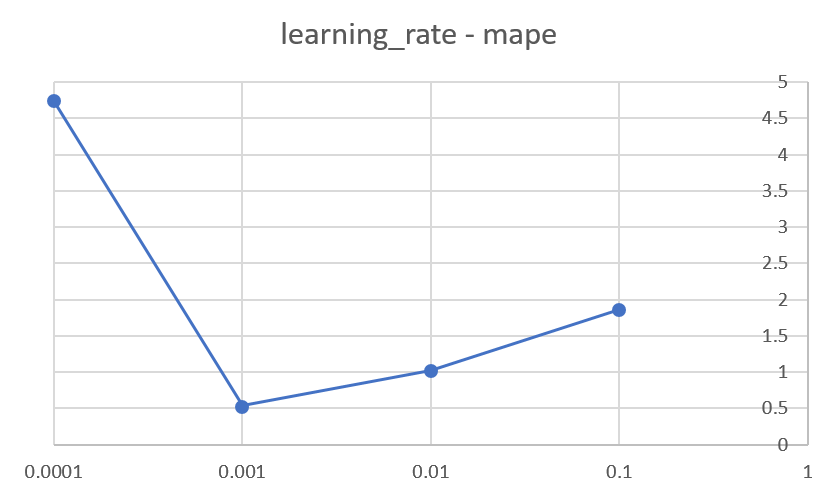

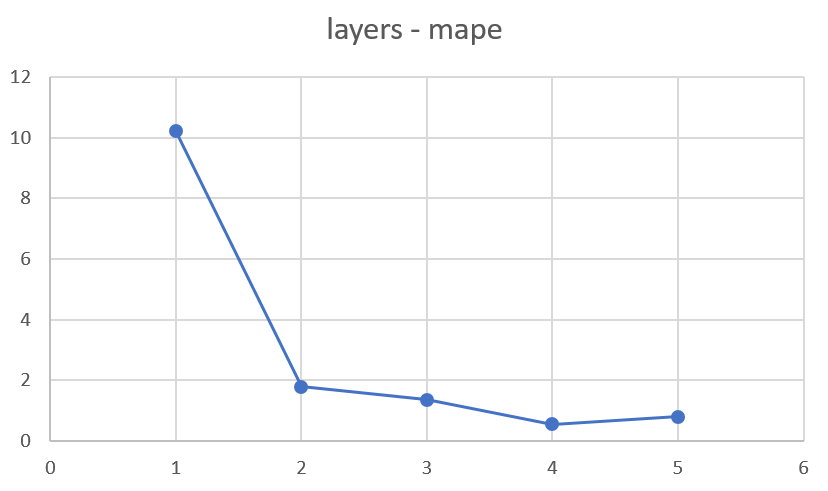

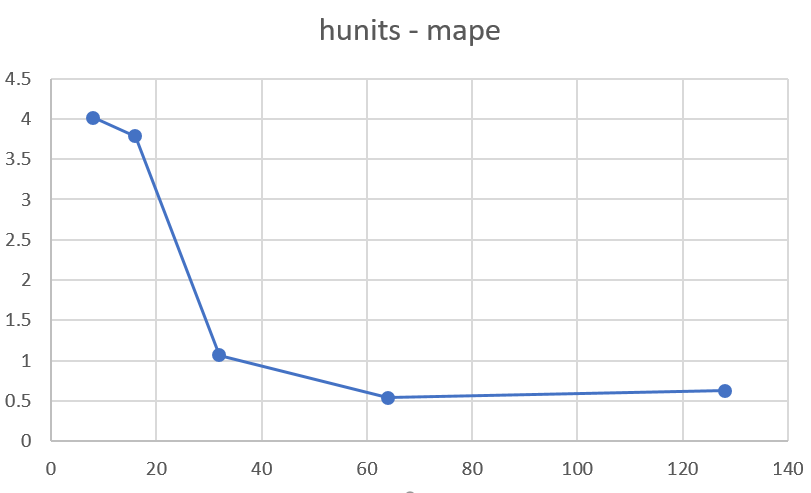